<a href="https://colab.research.google.com/github/JonathanMartignon/LicenciaturaCienciaDeDatos/blob/main/Computacion_Estadistica/Proyecto/Proyecto_Marti%C3%B1on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Eliminación de Ruido con Muestreo de Gibbs
## Martiñón Luna Jonathan José
## Licenciatura en Ciencia de Datos
## Semestre 2021 - II
Basado en:
- [towardsdatascience.com](https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153)
- [Github](https://github.com/VXU1230/Medium-Tutorials/tree/master/mcmc_gibbs)

# Librerías

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time
from PIL import Image
import cv2

# Funciones

In [2]:
def muestra_imagen(ruta = None, imagen = None, title = "Imagen",
                   save = False, figsize=(6,6), fig = False ,
                   sub = "subplot"):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada únicamente de mostrar
                   una imagen y su forma.

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a mostrar    STR

  imagen           En caso de no otorgar una ruta, se deberá      NUMPY.ARRAY
                   enviar la imagen directamente
  
  title            Título de la imagen                            STR

  save             Booleano que indicará si deseamos o no,        BOOL
                   almacenar la imagen

  figsize          Tamaño del lienzo (Figura) que almacena la     TUPLE
                   imagen
  
  fig              Booleano que indica si se necesita una figura  BOOL

  sub              Subtitulo en la etiqueta al alamacenar         STR

  @Devuelve:       None
  '''

  # En caso de existir una ruta
  if ruta:
    # Leemos la imagen a partir de ella
    img = plt.imread(ruta)

  # En otro caso, suponemos la existencia del envío de la imagen
  else:
    # Compiamos la imagen, para evitar sobreescribir la 'original'
    img = imagen.copy()
  if fig:
    # Generamos nuestro lienzo
    figure = plt.figure(figsize=figsize)

  # Mostramos la imagen con un mapa de gris
  plt.imshow(img, cmap="gray")

  try:
    # Ajustamos el título como el nombre de la imagen + la forma
    plt.title(f"{title}\nShape: {img.shape}")
  except:
    plt.title(f"{title}\nShape: {img.shape}")
  # Eliminamos los ejes tanto en X, como en Y
  plt.xticks([])
  plt.yticks([])
  
  # En caso de desear almacenarla
  if save:
    plt.savefig(f"./{title}_{sub}.png",format="png")

  if fig:
    # Mostramos la imagen
    plt.show()

In [10]:
def resize_image(ruta="./", resize =  (450,340)):

  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada únicamente de mostrar
                   una imagen y su forma.

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a preprocesar    STR

  resize           Tamaño nuevo de la imagen a mostrar                TUPLE

  @Devuelve:       

  resized_image    Imagen ajustada                                    NUMPY.ARRAY
  '''

  # Leemos la imagen a partir de ella
  image = Image.open(ruta)

  resized_image = image.resize(resize) 

  return np.array(resized_image)

In [56]:
def agrega_ruido(imagen,porcentaje=25.0):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada de agregar ruido (0,1) a una imagen

  @Parámetros: 

  imagen           Imagen a agregar Ruido                       NUMPY.ARRAY

  porcentaje       Porcentaje máximo de la imagen dónde se      FLOAT
                   agregará ruido

  @Devuelve:       

  noised_image    Imagen con ruido                              NUMPY.ARRAY
  '''

  # Capturamos las dimensiones de la imagen
  renglon,columna = imagen.shape

  # Para no afectar la original, copiamos el arreglo
  noised_image = imagen.copy()

  # Calculamos el total de pixeles a aplicar ruido
  total = renglon*columna
  pixeles = int(porcentaje * total / 100)

  # Realizamos un ciclo con la cantidad de pixeles a aplicar el RUIDO
  for i in range(pixeles):
    # Calculamos una posición aleatoria para el renglón
    pos_r = np.random.randint(0,renglon)

    # Calculamos una posición aleatoria para la columna
    pos_col = np.random.randint(0,columna)

    # Establecemos el valor de pixel entre 0 y 1 (ruido)
    noised_image[pos_r,pos_col] = np.random.randint(0,1)

  # Devolvemos la nueva imagen
  return noised_image


In [60]:
def preprocesa(ruta = "./", new_size=(450,340), porcentaje=25.0):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada de preprocesar la imagen

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a          STR
                   preprocesar    

  new_size         Tamaño nuevo de la imagen a mostrar          TUPLE

  porcentaje       Porcentaje máximo de la imagen dónde se      FLOAT
                   agregará ruido

  @Devuelve:       

  preprocesed_image    Imagen preprocesada                       NUMPY.ARRAY
  '''
  
  # Ajustamos el tamaño de la imagen
  res_image = resize_image(ruta=ruta, resize = new_size)

  # Convertimos a escalas de grises (1 canal)
  image_gray = cv2.cvtColor(res_image, cv2.COLOR_BGR2GRAY)

  # Agregamos un porcentaje de ruido 
  preprocesed_image = agrega_ruido(image_gray,porcentaje=porcentaje)

  # Devolvemos la imagen preprocesada
  return preprocesed_image

In [4]:
def denoise_image(filename, burn_in_steps, total_samples, logfile):
    posterior = get_posterior(filename, burn_in_steps, total_samples, logfile=logfile)
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior > 0.5] = 1
    return denoised[1:-1, 1:-1]

In [5]:
def get_posterior(filename, burn_in_steps, total_samples, logfile):
    X = load_image(filename)
    posterior = np.zeros(X.shape)
    print(X.shape)
    Y = np.random.choice([1, -1], size=X.shape)
    energy_list = list()
    for step in range(burn_in_steps + total_samples):
        for i in range(1, Y.shape[0]-1):
            for j in range(1, Y.shape[1]-1):
                y = sample_y(i, j, Y, X)
                Y[i, j] = y
                if y == 1 and step >= burn_in_steps:
                    posterior[i, j] += 1
        energy = -np.sum(np.multiply(Y, X))*ITA-(np.sum(np.multiply(Y[:-1], Y[1:]))+np.sum(np.multiply(Y[:, :-1], Y[:, 1:])))*BETA
        if step < burn_in_steps:
            energy_list.append(str(step) + "\t" + str(energy) + "\tB")
        else:
            energy_list.append(str(step) + "\t" + str(energy) + "\tS")
    posterior = posterior / total_samples

    file = open(logfile, 'w')
    for element in energy_list:
        file.writelines(element)
        file.write('\n')
    file.close()
    return posterior

In [6]:
def sample_y(i, j, Y, X):
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ITA * markov_blanket[-1] + BETA * sum(markov_blanket[:4])
    prob = 1 / (1 + math.exp(-2*w))
    return (np.random.rand() < prob) * 2 - 1

In [7]:
def plot_energy(filename):
    x = np.genfromtxt(filename, dtype=None, encoding='utf8')
    its, energies, phases = zip(*x)
    its = np.asarray(its)
    energies = np.asarray(energies)
    phases = np.asarray(phases)
    burn_mask = (phases == 'B')
    samp_mask = (phases == 'S')
    assert np.sum(burn_mask) + np.sum(samp_mask) == len(x), 'Found bad phase'
    its_burn, energies_burn = its[burn_mask], energies[burn_mask]
    its_samp, energies_samp = its[samp_mask], energies[samp_mask]
    p1, = plt.plot(its_burn, energies_burn, 'r')
    p2, = plt.plot(its_samp, energies_samp, 'b')
    plt.title("energy")
    plt.xlabel('iteration number')
    plt.ylabel('energy')
    plt.legend([p1, p2], ['burn in', 'sampling'])
    plt.savefig('%s.png' % filename)
    plt.close()

In [9]:
ITA = 1
BETA = 1
total_samples = 1000
burn_in_steps = 100

logfile = "output/log_energy.txt"

start = time()

denoised_img = denoise_image("data/img_noisy.png", burn_in_steps=burn_in_steps,
                             total_samples=total_samples, logfile=logfile)
plot_energy(logfile)
save_image(denoised_img)

print("Tardó: ",start-time())

NameError: ignored

# Carga de datos

In [ ]:
#!rm -r Data

In [11]:
!mkdir ./Data

In [12]:
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/butterfly.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/pattern-green.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/periquitos.jpg

# Análisis

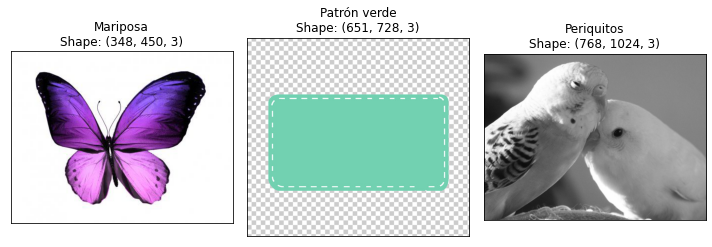

In [66]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(ruta = "Data/butterfly.jpg", title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(ruta = "Data/pattern-green.jpg", title = "Patrón verde")

plt.subplot(1,3,3)
muestra_imagen(ruta = "Data/periquitos.jpg", title = "Periquitos")

plt.tight_layout()
# plt.savefig("./DiferenciaDeFormas.png",format="png",bbox_inches='tight')
plt.show()

# Pre-procesamiento
Tal cual se puede apreciar de las imágenes anteriores, podemos darnos cuenta que no comparten mismas dimensiones (Alto o ancho), mientras que el número de canales continúa siendo el mismo en cada uno de los 3 casos, es por ello, que procederemos con un pre-procesamiento, dónde inicialmente buscaremos que nuestras imagenes tengan un estándar en cuando a tamaño.

Observamos que la menor dimensión resulta en la mariposa con 348 x 450

In [67]:
butter_resize = resize_image(ruta="Data/butterfly.jpg")
pattern_resize = resize_image(ruta="Data/pattern-green.jpg")
periquitos_resize = resize_image(ruta="Data/periquitos.jpg")

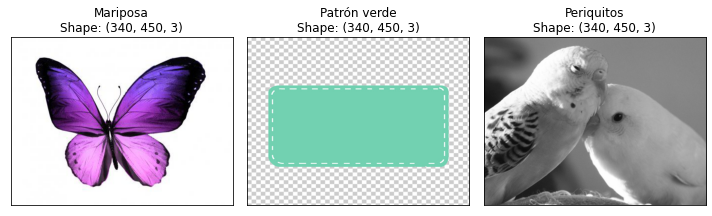

In [68]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = pattern_resize, title = "Patrón verde")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./AjusteDeFormas.png",format="png",bbox_inches='tight')
plt.show()

Una vez que contamos con nuestras imagenes en un estándar, procedemos a la reducción de canales.

3 => 1

In [69]:
butter_resize_gray = cv2.cvtColor(butter_resize, cv2.COLOR_BGR2GRAY)
pattern_resize_gray = cv2.cvtColor(pattern_resize, cv2.COLOR_BGR2GRAY)
periquitos_resize_gray = cv2.cvtColor(periquitos_resize, cv2.COLOR_BGR2GRAY)

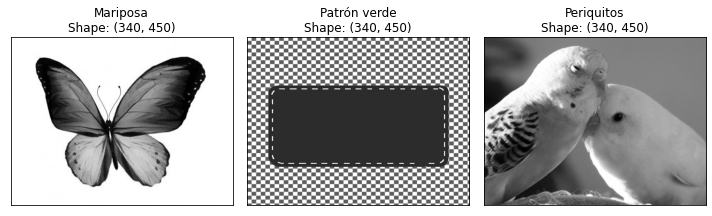

In [70]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize_gray, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = pattern_resize_gray, title = "Patrón verde")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize_gray, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./ReduccionCanales.png",format="png",bbox_inches='tight')
plt.show()

A este punto del proyecto contamos con un estándar en los tamaños, así como un único canal a analizar, es por ello que lo único que falta (no es muy difícil de identificar) es agregar ruido blanco a la imagen.

In [76]:
butter_resize_gray_noise = agrega_ruido(butter_resize_gray)
pattern_resize_gray_noise = agrega_ruido(pattern_resize_gray,porcentaje=50.0)
periquitos_resize_gray_noise = agrega_ruido(periquitos_resize_gray,porcentaje=50.0)

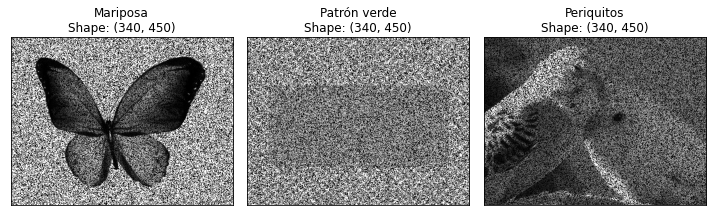

In [77]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize_gray_noise, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = pattern_resize_gray_noise, title = "Patrón verde")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize_gray_noise, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./Ruido_25_per.png",format="png",bbox_inches='tight')
plt.show()

Dado el análisis anterior, trabajaremos ya no sólo con las 3 imágenes, sino con 2 tipos de niveles de ruido
- Al 25%
- Al 5%

Por lo que finalemente generamos nuestros 2 conjuntos de datos

In [78]:
butter_noise_25 = preprocesa(ruta = "Data/butterfly.jpg")
pattern_noise_25 = preprocesa(ruta = "Data/pattern-green.jpg")
periquitos_noise_25 = preprocesa(ruta = "Data/periquitos.jpg")

In [79]:
butter_noise_10 = preprocesa(ruta = "Data/butterfly.jpg", porcentaje=5.0)
pattern_noise_10 = preprocesa(ruta = "Data/pattern-green.jpg", porcentaje=5.0)
periquitos_noise_10 = preprocesa(ruta = "Data/periquitos.jpg", porcentaje=5.0)

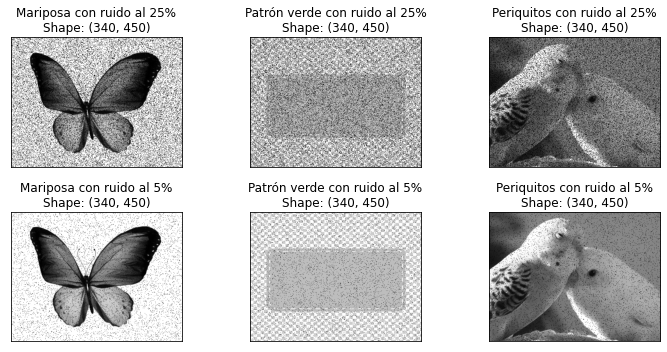

In [80]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
muestra_imagen(imagen = butter_noise_25, title = "Mariposa con ruido al 25%")

plt.subplot(2,3,2)
muestra_imagen(imagen = pattern_noise_25, title = "Patrón verde con ruido al 25%")

plt.subplot(2,3,3)
muestra_imagen(imagen = periquitos_noise_25, title = "Periquitos con ruido al 25%")


plt.subplot(2,3,4)
muestra_imagen(imagen = butter_noise_10, title = "Mariposa con ruido al 5%")

plt.subplot(2,3,5)
muestra_imagen(imagen = pattern_noise_10, title = "Patrón verde con ruido al 5%")

plt.subplot(2,3,6)
muestra_imagen(imagen = periquitos_noise_10, title = "Periquitos con ruido al 5%")


plt.tight_layout()
# plt.savefig("./Ruido_comparacion.png",format="png", bbox_inches='tight')
plt.show()